In [1]:
# Compute and plot the contour of the compact GP error model:
#   <(ΔI_GPR)^2> = α * G(ρ) / ΔQ + β * ΔQ^2 + γ * μ2(ρ)^2
# with α = β = γ = 1.
#
# Axes:
#   x-axis: ΔQ in [1e-2, 1e2] (log scale)
#   y-axis: ρ  in [1e-3, 1e1] (log scale)
# Contours are drawn for log10 of the value (i.e., "log-log-log" visualization).
#
# Implementation notes:
# - G(ρ) = θ3(0, e^{-ρ^2}) / θ3(0, e^{-ρ^2/2})^2
# - μ2(ρ) = ΔQ^2 * M2(ρ),  M2(ρ) = sum_m w_m m^2 with w_m ∝ exp(-0.5 ρ^2 m^2)
#   For small ρ (broad kernel), we use the continuum asymptotic M2 ≈ 1/ρ^2.
# - θ3 is evaluated robustly via modular transform:
#      θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
#   to ensure fast convergence near ρ → 0 (i.e., t → 0).
#
# Charting constraints:
# - Use matplotlib only.
# - Single figure (no subplots).
# - Do not set custom colors/styles.

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)


/tmp/ipykernel_1649007/3886203445.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


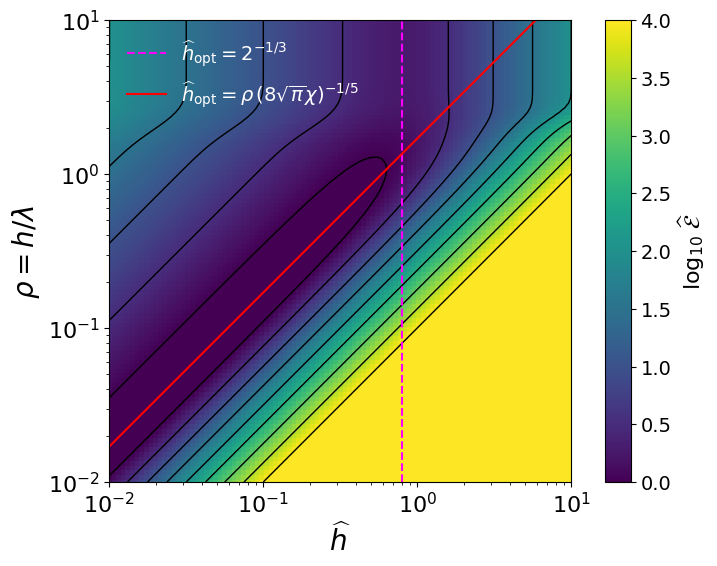

In [3]:
# ----------------------------
# Parameters and grids
# ----------------------------
dQ_vals = np.logspace(-2, 1, 101)   # \widehat{h}
rho_vals = np.logspace(-2, 1, 101)  # \rho = h / \lambda

# Optional: specify chi for small-ρ asymptotic line (only used for overlay)
chi = 1.0

# ----------------------------
# Evaluate reduced error surface \widehat{\mathcal{E}}(\widehat{h}, \rho)
# Eq. (\ref{eq:reduced-surface-no-rhostar})
# ----------------------------
Z = np.empty((rho_vals.size, dQ_vals.size), dtype=float)

for i, rho in enumerate(rho_vals):
    G = G_of_rho(rho)
    for j, dQ in enumerate(dQ_vals):
        mu2 = mu2_of_rho(rho, dQ)       # see note at the top
        val = G / dQ + dQ**2 + (mu2**2) # \widehat{\mathcal{E}}
        Z[i, j] = max(val, 1e-10)      # guard for log10

X, Y = np.meshgrid(dQ_vals, rho_vals)

# ----------------------------
# Asymptotic optimal lines \widehat{h}_{opt}(\rho)
# ----------------------------
# Large-ρ (weak/no smoothing): \widehat{h}_{opt} = 2^{-1/3}
dQ_opt_large = 2.0 ** (-1.0/3.0)

# Small-ρ (strong smoothing): \widehat{h}_{opt} ~ ρ * (1/(8 sqrt(pi) χ))^{1/5}
# Eq. (\ref{eq:opt-small-rho})
pref_small = (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)
dQ_opt_small_curve = rho_vals * pref_small

# ----------------------------
# Plot
# ----------------------------
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = fig.add_subplot(gs[0])
CS = ax.contour(X, Y, np.log10(Z), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')
CSf = ax.pcolormesh(X, Y, np.log10(Z), vmax=4, vmin=0, shading='nearest')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax.set_ylabel(r'$\rho=h/\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines (no explicit colors set)
# Large-ρ vertical line
ax.axvline(dQ_opt_large, linestyle='--', linewidth=1.5, label=r'$\widehat{h}_{\mathrm{opt}}=2^{-1/3}$', color="#FF00FF")
# Small-ρ curve
ax.plot(dQ_opt_small_curve, rho_vals, linestyle='-', linewidth=1.5,
        label=r'$\widehat{h}_{\mathrm{opt}}=\rho\,(8\sqrt{\pi}\chi)^{-1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='w')

ax.set_xlim(dQ_vals[0], dQ_vals[-1])
ax.set_ylim(rho_vals[0], rho_vals[-1])

# Colorbar
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(CSf, cax=cax)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Optional title (kept concise and aligned to manuscript labels)
# ax.set_title(r'Reduced error $\widehat{\mathcal{E}}(\widehat{h},\rho)$', fontsize=14)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1649007/2840838780.py:79: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, which='both', ls=':')


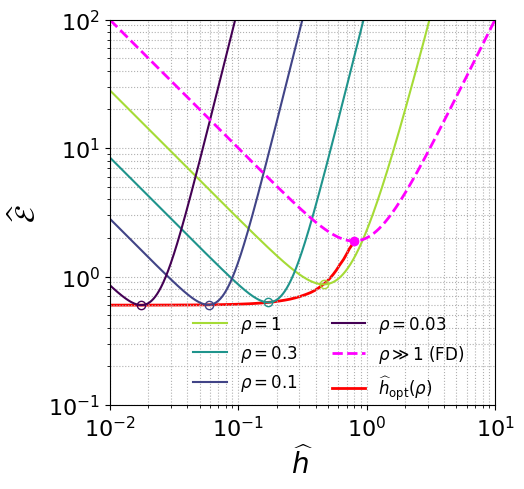

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))

# Plot each constant-rho slice with a color mapped to log10(rho)
import matplotlib.cm as cm

rho_slice_vals = [1, 0.3, 0.1, 0.03]
dQ_vals_fine = np.logspace(-3, 1, 801)
cmap = cm.viridis

for rho in rho_slice_vals:
    E_vals = []
    for dQ in dQ_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
    color = cmap((np.log10(rho) + 1.3) / 1.5)  # normalize log10(rho) to [0,1] for colormap
    ax.plot(dQ_vals_fine, E_vals, color=color, label=f"$\\rho={rho}$")
    # Plot minimum for each slice
    E_vals = np.array(E_vals)
    idx_min = np.argmin(E_vals)
    ax.plot(dQ_vals_fine[idx_min], E_vals[idx_min], 'o', color=color, fillstyle='none' )
    
# Finer slices: log-spaced rho values
rho_fine = np.logspace(np.log10(0.015), np.log10(10), 60)
dQ_min_list = []
E_min_list = []

for rho in rho_fine:
    E_vals = []
    for dQ in dQ_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
    E_vals = np.array(E_vals)
    idx_min = np.argmin(E_vals)
    dQ_min_list.append([dQ_vals_fine[idx_min]])
    E_min_list.append(E_vals[idx_min])

# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
# cbar.set_label(r'$\log_{10}\,\rho$', fontsize=14)

# Special case: rho >> 1 (large-ρ asymptotic)
E_large_rho = 1/dQ_vals_fine + dQ_vals_fine**2
ax.plot(dQ_vals_fine, E_large_rho, '--', color='magenta', lw=2, label=r'$\rho \gg 1$ (FD)')

# Find minimum and plot a marker
idx_min = np.argmin(E_large_rho)
dQ_min = dQ_vals_fine[idx_min]
E_min = E_large_rho[idx_min]
ax.plot(dQ_min, E_min, 'o', color='magenta')

# Connect minima with a red curve
ax.plot(dQ_min_list, E_min_list, color='red', lw=2, zorder=-2, label = '$\\widehat{h}_{\\mathrm{opt}}(\\rho)$')

# # Special case: rho << 1 (small-ρ asymptotic)
# rho_small = 0.01  # example small value
# rho = rho_small
# E_vals = []
# for dQ in dQ_vals_fine:
#     G = G_of_rho(rho)
#     mu2 = mu2_of_rho(rho, dQ)
#     val = G / dQ + dQ**2 + mu2**2
#     E_vals.append(val)
# E_vals = np.array(E_vals)
# ax.plot(dQ_vals_fine, E_vals, 'k:', lw=2, label=r'$\rho \ll 1$ (GP)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax.set_ylabel(r'$\widehat{\mathcal{E}}$', fontsize=20)
ax.set_ylim(1e-1, 1e2)
ax.set_xlim(1e-2, 1e1)
ax.legend(frameon = False, fontsize=12, ncol = 2, loc=(0.2, -0.01))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.grid(False, which='both', ls=':')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [5]:
np.log10(rho_slice_vals) +2

array([2.        , 1.47712125, 1.        , 0.47712125])

/tmp/ipykernel_1649007/2069911895.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


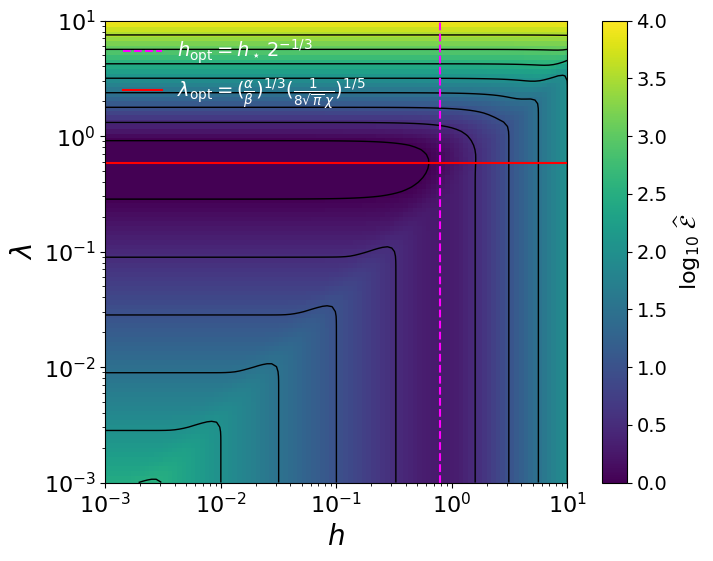

In [6]:
# ----------------------------
# Parameters and grids (PHYSICAL AXES)
# ----------------------------
# Set alpha, beta, chi per your data (chi used for small-ρ line only)
alpha = 1.0
beta  = 1.0
chi   = 1.0

# Characteristic bin width: ΔQ_* = (α/β)^{1/3}
DQ_star = (alpha / beta) ** (1.0/3.0)

# Physical grids
DQ_vals   = np.logspace(-3, 1, 101)   # ΔQ
lam_vals  = np.logspace(-3, 1, 101)   # λ

# Mesh and derived reduced vars
X_DQ, Y_lam   = np.meshgrid(DQ_vals, lam_vals)  # X=ΔQ, Y=λ
rho_grid      = X_DQ / Y_lam                    # ρ = ΔQ / λ
dQhat_grid    = X_DQ / DQ_star                  # \widehat{ΔQ}

# ----------------------------
# Evaluate reduced error surface \widehat{\mathcal{E}}(\widehat{ΔQ}, ρ)
# ----------------------------
Zhat = np.empty_like(rho_grid, dtype=float)
for i in range(rho_grid.shape[0]):
    for j in range(rho_grid.shape[1]):
        rho   = rho_grid[i, j]
        dQhat = dQhat_grid[i, j]
        G     = G_of_rho(rho)
        mu2   = mu2_of_rho(rho, dQhat)   # see note above
        val   = G / dQhat + dQhat**2 + (mu2**2)   # \widehat{\mathcal{E}}
        Zhat[i, j] = max(val, 1e-10)             # guard for log10

# ----------------------------
# Asymptotic optimal lines in (ΔQ, λ)
# ----------------------------
# Large-ρ: \widehat{ΔQ}_{opt} = 2^{-1/3}  ⇒  ΔQ_{opt} = ΔQ_*·2^{-1/3} (vertical)
DQ_opt_large = DQ_star * (2.0 ** (-1.0/3.0))

# Small-ρ: \widehat{ΔQ}_{opt} ~ ρ·(8√π χ)^{-1/5}
#          with ρ = ΔQ/λ ⇒ λ_{opt} = ΔQ_*·(8√π χ)^{-1/5} (horizontal)
lam_opt_small = DQ_star * (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)

# ----------------------------
# Plot (labels, fonts, sizes, colors as in your code)
# ----------------------------
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

ax = fig.add_subplot(gs[0])
CSf = ax.pcolormesh(X_DQ, Y_lam, np.log10(Zhat), vmax=4, vmin=0, shading='nearest')
CS = ax.contour(X_DQ, Y_lam, np.log10(Zhat), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$h$', fontsize=20)
ax.set_ylabel(r'$\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines with your colors/styles
# Large-ρ vertical line (magenta)
ax.axvline(DQ_opt_large, linestyle='--', linewidth=1.5,
           label=r'$h_{\mathrm{opt}}=h_\star\,2^{-1/3}$', color="#FF00FF")
# Small-ρ horizontal line (red)
ax.axhline(lam_opt_small, linestyle='-', linewidth=1.5,
           label=r'$\lambda_{\mathrm{opt}}=(\frac{\alpha}{\beta})^{1/3}(\frac{1}{8\sqrt{\pi}\,\chi})^{1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='w')

ax.set_xlim(DQ_vals[0], DQ_vals[-1])
ax.set_ylim(lam_vals[0], lam_vals[-1])

# Colorbar (same label/font sizes)
cax = fig.add_subplot(gs[1])
cbar = plt.colorbar(CSf, cax=cax)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


/tmp/ipykernel_1649007/763982611.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


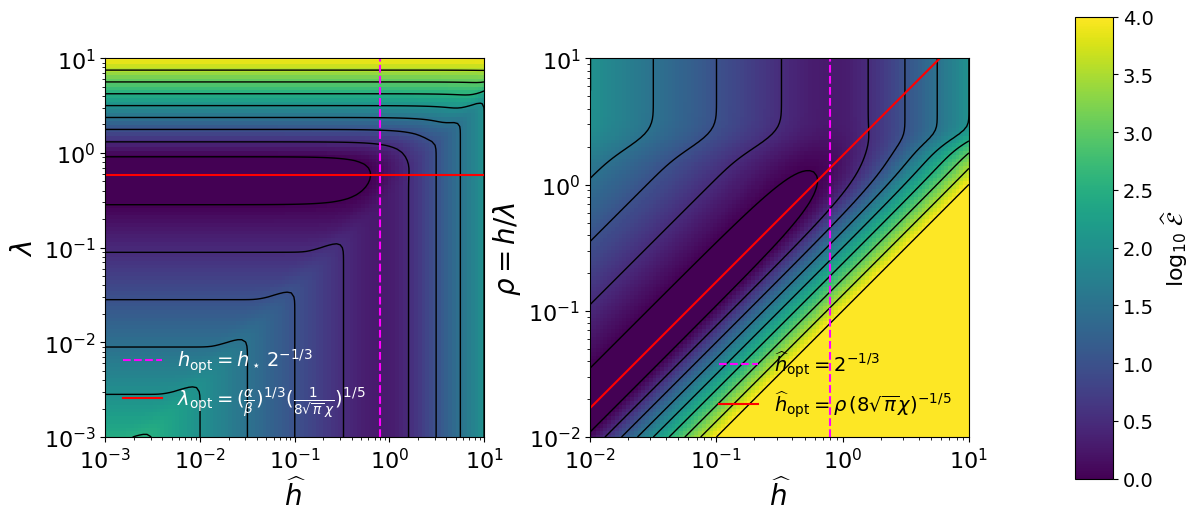

In [7]:
fig = plt.figure(figsize=(13, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[10, 10, 1], wspace=0.4)
ax = fig.add_subplot(gs[0])
# ----------------------------
CSf = ax.pcolormesh(X_DQ, Y_lam, np.log10(Zhat), vmax=4, vmin=0, shading='nearest')
CS = ax.contour(X_DQ, Y_lam, np.log10(Zhat), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax.set_ylabel(r'$\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines with your colors/styles
# Large-ρ vertical line (magenta)
ax.axvline(DQ_opt_large, linestyle='--', linewidth=1.5,
           label=r'$h_{\mathrm{opt}}=h_\star\,2^{-1/3}$', color="#FF00FF")
# Small-ρ horizontal line (red)
ax.axhline(lam_opt_small, linestyle='-', linewidth=1.5,
           label=r'$\lambda_{\mathrm{opt}}=(\frac{\alpha}{\beta})^{1/3}(\frac{1}{8\sqrt{\pi}\,\chi})^{1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='w', loc='lower left')

ax.set_xlim(DQ_vals[0], DQ_vals[-1])
ax.set_ylim(lam_vals[0], lam_vals[-1])

# # Colorbar (same label/font sizes)
# cax = fig.add_subplot(gs[1])
# cbar = plt.colorbar(CSf, cax=cax)
# cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
# cbar.ax.tick_params(labelsize=14)

ax = fig.add_subplot(gs[1])
# ----------------------------
CS = ax.contour(X, Y, np.log10(Z), levels=np.linspace(0, 4, 9), linewidths=1, colors='k')
CSf = ax.pcolormesh(X, Y, np.log10(Z), vmax=4, vmin=0, shading='nearest')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax.set_ylabel(r'$\rho=h/\lambda$', fontsize=20)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)

# Overlay asymptotic lines (no explicit colors set)
# Large-ρ vertical line
ax.axvline(dQ_opt_large, linestyle='--', linewidth=1.5, label=r'$\widehat{h}_{\mathrm{opt}}=2^{-1/3}$', color="#FF00FF")
# Small-ρ curve
ax.plot(dQ_opt_small_curve, rho_vals, linestyle='-', linewidth=1.5,
        label=r'$\widehat{h}_{\mathrm{opt}}=\rho\,(8\sqrt{\pi}\chi)^{-1/5}$', color='r')

ax.legend(fontsize=14, frameon=False, labelcolor='k')

ax.set_xlim(dQ_vals[0], dQ_vals[-1])
ax.set_ylim(rho_vals[0], rho_vals[-1])

# Colorbar
cax = fig.add_subplot(gs[2])
cbar = plt.colorbar(CSf, cax=cax)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()

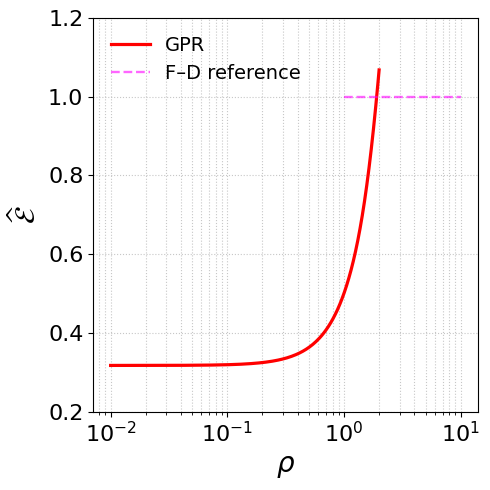

(0.01, 0.3171235998956179, 1.8898815748423097)

In [8]:
# Parameters
chi = 1.0

# Baseline ρ grid to evaluate and find the red-path minimum
rho_all = np.logspace(-2, 1, 400)

# Paths
dQ_FD = 2.0 ** (-1.0/3.0)
pref_small = (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)
dQ_small_all = rho_all * pref_small

# Evaluate total reduced error along each path on the wide grid
E_FD_all = np.empty_like(rho_all)
E_small_all = np.empty_like(rho_all)
for i, rho in enumerate(rho_all):
    G = G_of_rho(rho)
    mu2_FD = mu2_of_rho(rho, dQ_FD)
    mu2_small = mu2_of_rho(rho, dQ_small_all[i])
    E_FD_all[i] = G / dQ_FD + dQ_FD**2 + mu2_FD**2
    E_small_all[i] = G / dQ_small_all[i] + dQ_small_all[i]**2 + mu2_small**2

rho_extreme = 1e4 
E_FD_extreme = G_of_rho(rho_extreme) / dQ_FD + dQ_FD**2 + mu2_of_rho(rho_extreme, dQ_FD)**2

# Locate minimum of red path and define requested ranges
idx_min_small = np.argmin(E_small_all)
rho_min_small = rho_all[idx_min_small]

# Build the plotting ranges
rho_red = np.logspace(np.log10(rho_min_small), np.log10(2.0), 240)
dQ_red = rho_red * pref_small
E_red = np.empty_like(rho_red)
for i, rho in enumerate(rho_red):
    G = G_of_rho(rho)
    mu2 = mu2_of_rho(rho, dQ_red[i])
    E_red[i] = G / dQ_red[i] + dQ_red[i]**2 + mu2**2

rho_mag = np.logspace(0, 1, 240)  # FD path for ρ ∈ [1, 10]
E_mag = np.empty_like(rho_mag)
for i, rho in enumerate(rho_mag):
    G = G_of_rho(rho)
    mu2 = mu2_of_rho(rho, dQ_FD)
    E_mag[i] = G / dQ_FD + dQ_FD**2 + mu2**2

# For your "flat" FD reference over the whole axis, keep a separate line if desired
rho_flat = np.logspace(0, 1, 240)
E_flat = np.ones_like(rho_flat) * E_FD_extreme

# ---- OO-style plotting ----
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(rho_red, E_red/E_FD_extreme, '-', linewidth=2.3, color='red', label='GPR')
# ax.loglog(rho_mag, E_mag/E_FD_extreme, '-', linewidth=2.3, color='magenta', label='F–D (ρ≥1)')
ax.plot(rho_flat, E_flat/E_FD_extreme, '--', linewidth=1.7, color='magenta', alpha=0.6, label='F–D reference')
ax.set_xscale('log')

ax.set_xlabel(r'$\rho$', fontsize=20)
ax.set_ylabel(r'$\widehat{\mathcal{E}}$', fontsize=20)
ax.grid(True, which='both', ls=':', alpha=0.7)
ax.tick_params(axis='both', labelsize=16)
ax.legend(frameon=False, fontsize=14)
ax.set_ylim(2e-1,1.2)

fig.tight_layout()
plt.show()

rho_min_small, E_small_all[idx_min_small]/E_FD_extreme, E_FD_extreme


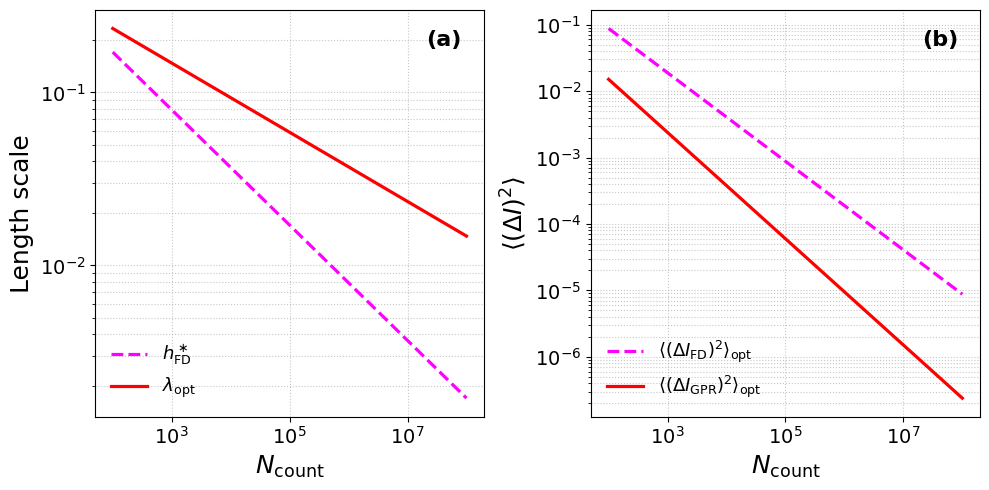

In [9]:
# ---------- Parameters (adjustable) ----------
L = 1.0
mean_I = 1.0
beta = 1.0
gamma = 1.0

# Derived constant:
A0 = L * (mean_I**2)  # equals L * CI^2 where CI is the interval-mean intensity

# Counts range (log-spaced)
N = np.logspace(2, 8, 400)  # 1e2 ... 1e8

# ---------- Panel A: Length scales vs counts ----------
# ΔQ_FD = (α/β)^{1/3} * 2^{-1/3}, where α = A0 / N
DeltaQ_FD = ((A0 / (beta * N))**(1/3)) * (2.0 ** (-1.0/3.0))

# λ_opt (strong-smoothing) = ( A0 / (8√π γ N) )^{1/5}
lambda_opt = (A0 / (8.0 * math.sqrt(math.pi) * gamma * N))**(1.0/5.0)

fig = plt.figure(figsize=(10, 5))
panels_text = ['(a)', '(b)']

ax1 = fig.add_subplot(1, 2, 1)
ax1.loglog(N, DeltaQ_FD, '--', linewidth=2.3, label=r'$h_{\mathrm{FD}}^\ast$', color='magenta')
ax1.loglog(N, lambda_opt, '-', linewidth=2.3, label=r'$\lambda_{\mathrm{opt}}$', color='red')
ax1.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
ax1.set_ylabel(r'Length scale', fontsize=18)
ax1.grid(True, which='both', ls=':', alpha=0.7)
ax1.tick_params(axis='both', labelsize=14)
ax1.legend(frameon=False, fontsize=13, loc='lower left')
ax1.text(0.85, 0.95, panels_text[0], transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# ax1.set_title('Panel A: Optimal length scales vs. counts', fontsize=14)

# ---------- Panel B: Optimal total error vs counts ----------
# E_FD^min  = α^{2/3} β^{1/3} (2^{1/3}+2^{-2/3})
C_FD = (2.0 ** (1.0/3.0)) + (2.0 ** (-2.0/3.0))
E_FD = ((A0 / N)**(2.0/3.0)) * (beta**(1.0/3.0)) * C_FD

# E_GPR^min (strong) = (5/4)(2π)^(-2/5) * γ^{1/5} * A0^{4/5} * N^{-4/5}
C_GPR = (5.0/4.0) * ((2.0 * math.pi) ** (-2.0/5.0))
E_GPR = C_GPR * (gamma ** (1.0/5.0)) * (A0 ** (4.0/5.0)) * (N ** (-4.0/5.0))

ax2 = fig.add_subplot(1, 2, 2)
ax2.loglog(N, E_FD, '--', linewidth=2.3, label=r'$\langle(\Delta I_{\mathrm{FD}})^2\rangle_{\mathrm{opt}}$', color='magenta')
ax2.loglog(N, E_GPR, '-', linewidth=2.3, label=r'$\langle(\Delta I_{\mathrm{GPR}})^2\rangle_{\mathrm{opt}}$', color='red')
ax2.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
ax2.set_ylabel(r'$\langle(\Delta I)^2\rangle$', fontsize=18)
ax2.grid(True, which='both', ls=':', alpha=0.7)
ax2.tick_params(axis='both', labelsize=14)
ax2.legend(frameon=False, fontsize=13, loc='lower left')
ax2.text(0.85, 0.95, panels_text[1], transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# ax2.set_title('Panel B: Optimal deviation vs. counts', fontsize=14)
plt.tight_layout()

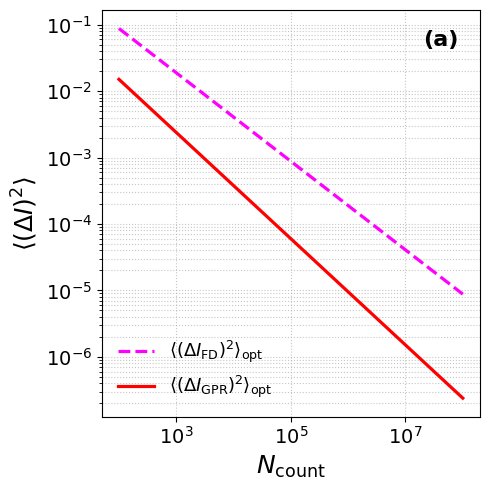

In [10]:
# ---------- Parameters (adjustable) ----------
L = 1.0
mean_I = 1.0
beta = 1.0
gamma = 1.0

# Derived constant:
A0 = L * (mean_I**2)  # equals L * CI^2 where CI is the interval-mean intensity

# Counts range (log-spaced)
N = np.logspace(2, 8, 400)  # 1e2 ... 1e8

# ---------- Panel A: Length scales vs counts ----------
# ΔQ_FD = (α/β)^{1/3} * 2^{-1/3}, where α = A0 / N
DeltaQ_FD = ((A0 / (beta * N))**(1/3)) * (2.0 ** (-1.0/3.0))

# λ_opt (strong-smoothing) = ( A0 / (8√π γ N) )^{1/5}
lambda_opt = (A0 / (8.0 * math.sqrt(math.pi) * gamma * N))**(1.0/5.0)

fig = plt.figure(figsize=(5, 5))
panels_text = ['(a)', '(b)']

# ax1 = fig.add_subplot(1, 2, 1)
# ax1.loglog(N, DeltaQ_FD, '--', linewidth=2.3, label=r'$h_{\mathrm{FD}}^\ast$', color='magenta')
# ax1.loglog(N, lambda_opt, '-', linewidth=2.3, label=r'$\lambda_{\mathrm{opt}}$', color='red')
# ax1.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
# ax1.set_ylabel(r'Length scale', fontsize=18)
# ax1.grid(True, which='both', ls=':', alpha=0.7)
# ax1.tick_params(axis='both', labelsize=14)
# ax1.legend(frameon=False, fontsize=13, loc='lower left')
# ax1.text(0.85, 0.95, panels_text[0], transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# # ax1.set_title('Panel A: Optimal length scales vs. counts', fontsize=14)

# ---------- Panel B: Optimal total error vs counts ----------
# E_FD^min  = α^{2/3} β^{1/3} (2^{1/3}+2^{-2/3})
C_FD = (2.0 ** (1.0/3.0)) + (2.0 ** (-2.0/3.0))
E_FD = ((A0 / N)**(2.0/3.0)) * (beta**(1.0/3.0)) * C_FD

# E_GPR^min (strong) = (5/4)(2π)^(-2/5) * γ^{1/5} * A0^{4/5} * N^{-4/5}
C_GPR = (5.0/4.0) * ((2.0 * math.pi) ** (-2.0/5.0))
E_GPR = C_GPR * (gamma ** (1.0/5.0)) * (A0 ** (4.0/5.0)) * (N ** (-4.0/5.0))

ax2 = fig.add_subplot(1, 1, 1)
ax2.loglog(N, E_FD, '--', linewidth=2.3, label=r'$\langle(\Delta I_{\mathrm{FD}})^2\rangle_{\mathrm{opt}}$', color='magenta')
ax2.loglog(N, E_GPR, '-', linewidth=2.3, label=r'$\langle(\Delta I_{\mathrm{GPR}})^2\rangle_{\mathrm{opt}}$', color='red')
ax2.set_xlabel(r'$N_{\mathrm{count}}$', fontsize=18)
ax2.set_ylabel(r'$\langle(\Delta I)^2\rangle$', fontsize=18)
ax2.grid(True, which='both', ls=':', alpha=0.7)
ax2.tick_params(axis='both', labelsize=14)
ax2.legend(frameon=False, fontsize=13, loc='lower left')
ax2.text(0.85, 0.95, panels_text[0], transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
# ax2.set_title('Panel B: Optimal deviation vs. counts', fontsize=14)
plt.tight_layout()

0.5
0.16666666666666666


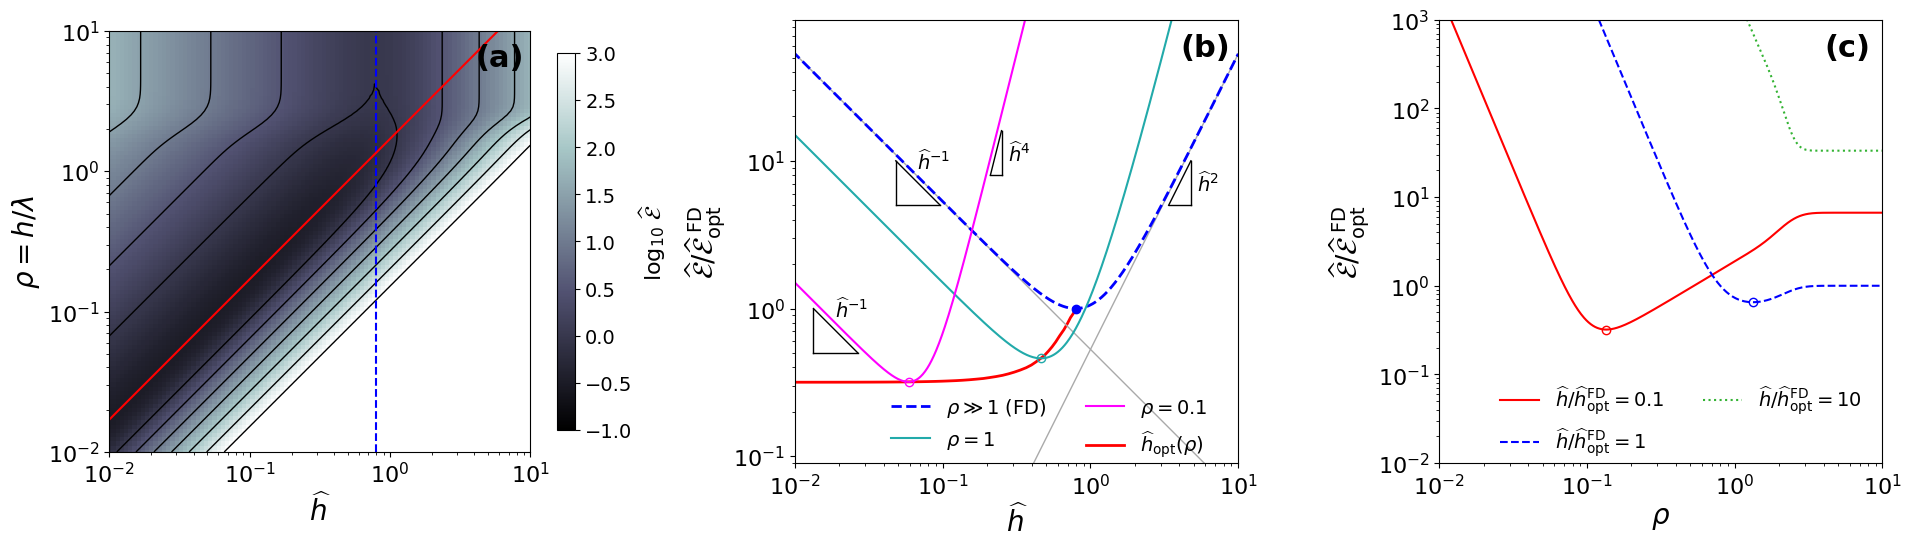

In [11]:
## Panel A

# ----------------------------
# Parameters and grids
# ----------------------------
dQ_vals = np.logspace(-2, 1, 101)   # \widehat{h}
rho_vals = np.logspace(-2, 1, 101)  # \rho = h / \lambda

# Optional: specify chi for small-ρ asymptotic line (only used for overlay)
chi = 1.0

# ----------------------------
# Evaluate reduced error surface \widehat{\mathcal{E}}(\widehat{h}, \rho)
# Eq. (\ref{eq:reduced-surface-no-rhostar})
# ----------------------------
Z = np.empty((rho_vals.size, dQ_vals.size), dtype=float)

for i, rho in enumerate(rho_vals):
    G = G_of_rho(rho)
    for j, dQ in enumerate(dQ_vals):
        mu2 = mu2_of_rho(rho, dQ)       # see note at the top
        val = G / dQ + dQ**2 + (mu2**2) # \widehat{\mathcal{E}}
        Z[i, j] = max(val, 1e-10)/E_FD_extreme      # guard for log10

X, Y = np.meshgrid(dQ_vals, rho_vals)

# ----------------------------
# Asymptotic optimal lines \widehat{h}_{opt}(\rho)
# ----------------------------
# Large-ρ (weak/no smoothing): \widehat{h}_{opt} = 2^{-1/3}
dQ_opt_large = 2.0 ** (-1.0/3.0)

# Small-ρ (strong smoothing): \widehat{h}_{opt} ~ ρ * (1/(8 sqrt(pi) χ))^{1/5}
# Eq. (\ref{eq:opt-small-rho})
pref_small = (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)
dQ_opt_small_curve = rho_vals * pref_small

# ----------------------------
# Plot
# ----------------------------
# fig = plt.figure(figsize=(13, 6))
# gs = gridspec.GridSpec(1, 3, width_ratios=[20, 1, 20], wspace=0.5)

fig, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize=(19, 5))
CS = ax1.contour(X, Y, np.log10(Z), levels=np.linspace(-1, 3, 9), linewidths=1, colors='k')
CSf = ax1.pcolormesh(X, Y, np.log10(Z), vmax=3, vmin=-1, shading='nearest', cmap='bone')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax1.set_ylabel(r'$\rho=h/\lambda$', fontsize=20)
ax1.set_aspect('equal', adjustable='box')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.text(0.87, 0.97, '(a)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='left', color='k')

# Overlay asymptotic lines (no explicit colors set)
# Large-ρ vertical line
ax1.axvline(dQ_opt_large, linestyle='--', linewidth=1.5, label=r'$\widehat{h}_{\mathrm{opt}}=2^{-1/3}$', color="b")

# Small-ρ curve
ax1.plot(dQ_opt_small_curve, rho_vals, linestyle='-', linewidth=1.5,
        label=r'$\widehat{h}_{\mathrm{opt}}=\rho\,(8\sqrt{\pi}\chi)^{-1/5}$', color='r')

# ax1.legend(fontsize=14, frameon=False, labelcolor='w')

ax1.set_xlim(dQ_vals[0], dQ_vals[-1])
ax1.set_ylim(rho_vals[0], rho_vals[-1])

# Colorbar
# cax = fig.add_subplot(gs[1])
# cbar = plt.colorbar(CSf, cax=cax)
cbar = plt.colorbar(CSf, ax=ax1, shrink=0.85)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)


## Panel B
# Plot each constant-rho slice with a color mapped to log10(rho)
import matplotlib.cm as cm

rho_slice_vals = [1, 0.1]
color_list = ['#22AAAA', '#FF00FF']
dQ_vals_fine = np.logspace(-3, 1, 801)
cmap = cm.hot

# Special case: rho >> 1 (large-ρ asymptotic)
E_large_rho = 1/dQ_vals_fine + dQ_vals_fine**2
ax3.plot(dQ_vals_fine, 1/dQ_vals_fine/E_FD_extreme, '-', color='#AAAAAA', lw=1)
y_triangle = np.array([5, 10])
x_triangle = 1/y_triangle/E_FD_extreme/1.1
ax3.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.text(x_triangle[1]*1.4, np.sqrt(y_triangle[0]*y_triangle[1])*1.4, r"$\widehat{h}^{-1}$", fontsize=14, va='center', ha='left', color='k')

ax3.plot(dQ_vals_fine, dQ_vals_fine**2/E_FD_extreme, '-', color='#AAAAAA', lw=1)
y_triangle = np.array([5, 10])
x_triangle = np.sqrt(y_triangle*E_FD_extreme)*1.1
ax3.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.text(x_triangle[1]*1.1, np.sqrt(y_triangle[0]*y_triangle[1]), r"$\widehat{h}^{2}$", fontsize=14, va='center', ha='left', color='k')

ax3.plot(dQ_vals_fine, E_large_rho/E_FD_extreme, '--', color='b', lw=2, label=r'$\rho \gg 1$ (FD)')


for rho in rho_slice_vals:
    E_vals = []
    for dQ in dQ_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
    E_vals = np.array(E_vals)
    color = cmap((np.log10(rho) +1.5)/3)  # normalize log10(rho) to [0,1] for colormap
    color = color_list[rho_slice_vals.index(rho)]
    print((np.log10(rho) +1.5)/3)
    ax3.plot(dQ_vals_fine, E_vals/E_FD_extreme, color=color, label=f"$\\rho={rho}$")
    # Plot minimum for each slice
    E_vals = np.array(E_vals)
    idx_min = np.argmin(E_vals)
    ax3.plot(dQ_vals_fine[idx_min], E_vals[idx_min]/E_FD_extreme, 'o', color=color, fillstyle='none' )
    
# Finer slices: log-spaced rho values
rho_fine = np.logspace(np.log10(0.015), np.log10(10), 60)
dQ_min_list = []
E_min_list = []

for rho in rho_fine:
    E_vals = []
    for dQ in dQ_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
    E_vals = np.array(E_vals)
    idx_min = np.argmin(E_vals)
    dQ_min_list.append([dQ_vals_fine[idx_min]])
    E_min_list.append(E_vals[idx_min])
E_min_list = np.array(E_min_list)

y_triangle = np.array([8, 16])
x_triangle = y_triangle**(1/4)/8
ax3.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.text(x_triangle[1]*1.1, np.sqrt(y_triangle[0]*y_triangle[1]), r"$\widehat{h}^{4}$", fontsize=14, va='center', ha='left', color='k')
y_triangle = np.array([0.5, 1])
x_triangle = 1/y_triangle/75
ax3.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='k', lw=1)
ax3.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='k', lw=1)
ax3.text(x_triangle[1]*1.4, np.sqrt(y_triangle[0]*y_triangle[1])*1.4, r"$\widehat{h}^{-1}$", fontsize=14, va='center', ha='left', color='k')

# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
# cbar.set_label(r'$\log_{10}\,\rho$', fontsize=14)

# Find minimum and plot a marker
idx_min = np.argmin(E_large_rho)
dQ_min = dQ_vals_fine[idx_min]
E_min = E_large_rho[idx_min]
ax3.plot(dQ_min, E_min/E_FD_extreme, 'o', color='b')

# Connect minima with a red curve
ax3.plot(dQ_min_list, E_min_list/E_FD_extreme, color='red', lw=2, zorder=-2, label = '$\\widehat{h}_{\\mathrm{opt}}(\\rho)$')

# # Special case: rho << 1 (small-ρ asymptotic)
# rho_small = 0.01  # example small value
# rho = rho_small
# E_vals = []
# for dQ in dQ_vals_fine:
#     G = G_of_rho(rho)
#     mu2 = mu2_of_rho(rho, dQ)
#     val = G / dQ + dQ**2 + mu2**2
#     E_vals.append(val)
# E_vals = np.array(E_vals)
# ax3.plot(dQ_vals_fine, E_vals, 'k:', lw=2, label=r'$\rho \ll 1$ (GP)')

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax3.set_ylabel(r'$\widehat{\mathcal{E}}/\widehat{\mathcal{E}}_\mathrm{opt}^\mathrm{\ FD}$', fontsize=20)
ax3.set_ylim(9e-2, 9e1)
ax3.set_xlim(1e-2, 1e1)
ax3.legend(frameon = False, fontsize=14, ncol = 2, loc=(0.2, -0.01))
ax3.tick_params(axis='both', which='major', labelsize=16)
# ax3.grid(False, which='both', ls=':')
ax3.set_aspect('equal')
ax3.text(0.87, 0.97, '(b)', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top', ha='left', color='k')

## Panel C
dQ_slice_vals = (np.logspace(-1, 1, 3)*dQ_opt_large).tolist()
rho_vals_fine = np.logspace(-2, 1, 601)

# Separate dQ_slice_vals into sub-FD (below dQ_opt_large), exactly FD, and above FD
dQ_subFD = [dQ for dQ in dQ_slice_vals if dQ < dQ_opt_large]
dQ_exactFD = [dQ for dQ in dQ_slice_vals if np.isclose(dQ, dQ_opt_large)]
dQ_aboveFD = [dQ for dQ in dQ_slice_vals if dQ > dQ_opt_large]

# Plot sub-FD group (red-ish)
red_colors = ['#FF0000', '#E57373', '#B71C1C', '#FF5252']  # example distinct reds
for idx, dQ in enumerate(dQ_subFD):
    E_vals = []
    for rho in rho_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
    E_vals = np.array(E_vals)
    color = red_colors[idx % len(red_colors)]
    ax4.plot(rho_vals_fine, E_vals/E_FD_extreme, color=color, linestyle='-', label=f"$\\widehat{{h}}/\\widehat{{h}}_{{\\mathrm{{opt}}}}^{{\\mathrm{{FD}}}}={dQ/dQ_opt_large:.2g}$")
    idx_min = np.argmin(E_vals)
    ax4.plot(rho_vals_fine[idx_min], E_vals[idx_min]/E_FD_extreme, 'o', color=color, fillstyle='none')

# Plot exactly FD group (blue)
for dQ in dQ_exactFD:
    E_vals = []
    for rho in rho_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
    E_vals = np.array(E_vals)
    color = 'b'
    ax4.plot(rho_vals_fine, E_vals/E_FD_extreme, color=color, linestyle='--', label=f"$\\widehat{{h}}/\\widehat{{h}}_{{\\mathrm{{opt}}}}^{{\\mathrm{{FD}}}}={dQ/dQ_opt_large:.2g}$")
    idx_min = np.argmin(E_vals)
    ax4.plot(rho_vals_fine[idx_min], E_vals[idx_min]/E_FD_extreme, 'o', color=color, fillstyle='none')

# Plot above FD group (green-ish)
for dQ in dQ_aboveFD:
    E_vals = []
    for rho in rho_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
    E_vals = np.array(E_vals)
    color = (0.2, 0.7, 0.2)  # green-ish
    ax4.plot(rho_vals_fine, E_vals/E_FD_extreme, color=color, linestyle=':', label=f"$\\widehat{{h}}/\\widehat{{h}}_{{\\mathrm{{opt}}}}^{{\\mathrm{{FD}}}}={dQ/dQ_opt_large:.2g}$")
    # idx_min = np.argmin()
    # ax4.plot(rho_vals_fine[idxE_vals_min], E_vals[idx_min]/E_FD_extreme, 'o', color=color, fillstyle='none')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel(r'$\rho$', fontsize=20)
ax4.set_ylabel(r'$\widehat{\mathcal{E}}/\widehat{\mathcal{E}}_\mathrm{opt}^\mathrm{\ FD}$', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=16)
ax4.set_ylim(1e-2, 1e3)
ax4.set_xlim(1e-2, 1e1)
ax4.set_aspect(3/5)
ax4.legend(frameon = False, fontsize=14, ncol = 2, loc=(0.12, -0.01))
ax4.text(0.87, 0.97, '(c)', transform=ax4.transAxes, fontsize=22, fontweight='bold', va='top', ha='left', color='k')

plt.tight_layout(pad=-1)
plt.show()

0.16666666666666666
0.5
2.5


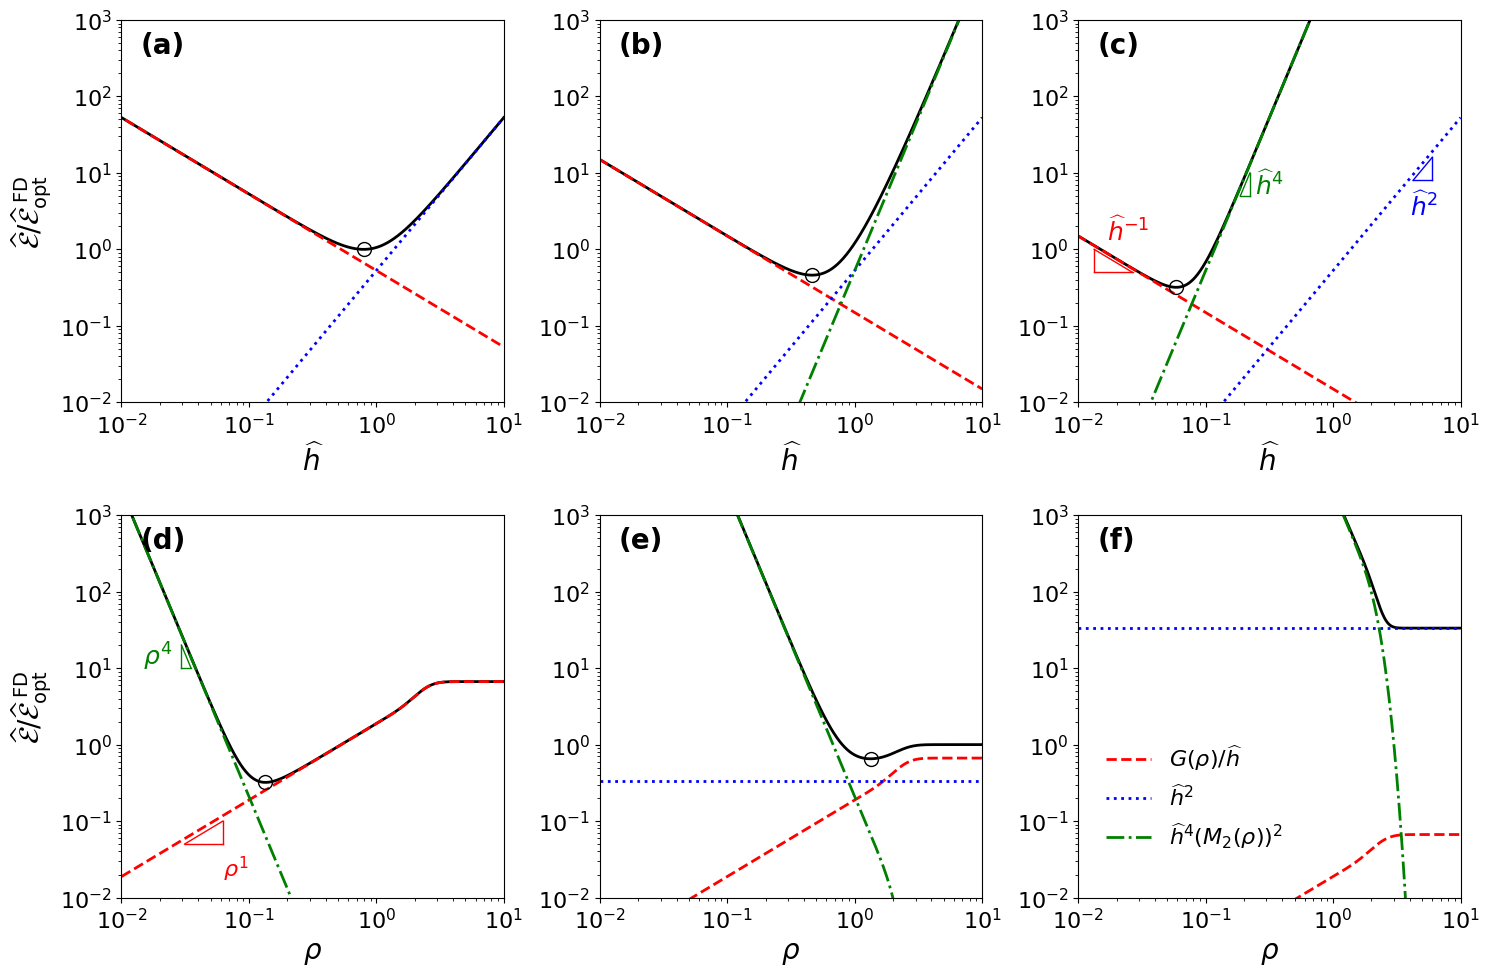

In [12]:
## slices
fig, axs_2r = plt.subplots(2, 3, figsize=(15, 10))

# rho slices
rho_slice_vals = [0.1, 1, 1e6]
color_list = ['#FF0000', '#22AAAA', '#FF00FF']
dQ_vals_fine = np.logspace(-3, 1, 801)

axis_labels = ['(a)', '(b)', '(c)']
axs = axs_2r[0, :]

for rho in rho_slice_vals:
    ax = axs[2-rho_slice_vals.index(rho)]
    E_vals = []
    E_vals_n1 = []
    E_vals_2 = []
    E_vals_4 = []
    for dQ in dQ_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
        E_vals_n1.append(G / dQ)
        E_vals_2.append(dQ**2)
        E_vals_4.append(mu2**2)
    E_vals = np.array(E_vals)
    E_vals_n1 = np.array(E_vals_n1)
    E_vals_2 = np.array(E_vals_2)
    E_vals_4 = np.array(E_vals_4)
    #
    color = cmap((np.log10(rho) +1.5)/3)  # normalize log10(rho) to [0,1] for colormap
    color = color_list[rho_slice_vals.index(rho)]
    print((np.log10(rho) +1.5)/3)
    label = f"$\\rho={rho}$"
    if rho>10:
        label = r'$\rho \gg 1$ (FD)'
    ax.plot(dQ_vals_fine, E_vals/E_FD_extreme, color='k', lw=2, zorder=-10)
    # ax.plot(dQ_vals_fine, E_vals/E_FD_extreme, '', label=label, color='w', lw=1e-6)
    ax.plot(dQ_vals_fine, E_vals_n1/E_FD_extreme, color='r', linestyle='--', lw=2, label=r'$G(\rho)/\widehat{h}$')
    ax.plot(dQ_vals_fine, E_vals_2/E_FD_extreme, color='b', linestyle=':', lw=2, label=r'$\widehat{h}^2$')
    ax.plot(dQ_vals_fine, E_vals_4/E_FD_extreme, color='g', linestyle='-.', lw=2, label=r'$\widehat{h}^4(M_2(\rho))^2$')
    # Plot minimum for each slice
    E_vals = np.array(E_vals)
    idx_min = np.argmin(E_vals)
    ax.plot(dQ_vals_fine[idx_min], E_vals[idx_min]/E_FD_extreme, 'o', color='k', fillstyle='none', markersize=10)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\widehat{h}$', fontsize=20)
    if rho==rho_slice_vals[2]:
        ax.set_ylabel(r'$\widehat{\mathcal{E}}/\widehat{\mathcal{E}}_\mathrm{opt}^\mathrm{\ FD}$', fontsize=20)
    ax.set_ylim(1e-2, 1e3)
    ax.set_xlim(1e-2, 1e1)
    # if rho<1:
    #     ax.legend(frameon = False, fontsize=12, ncol = 1, loc=(0, 0.6))
    ax.tick_params(axis='both', which='major', labelsize=16)
    # ax3.grid(False, which='both', ls=':')
    ax.set_aspect(3/5)
    ax.text(0.05, 0.97, axis_labels[2-rho_slice_vals.index(rho)], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='k')
    
    # red curve of minima    
    rho_fine = np.logspace(np.log10(0.015), np.log10(10), 60)
    dQ_min_list = []
    E_min_list = []

    for rho in rho_fine:
        E_vals = []
        for dQ in dQ_vals_fine:
            G = G_of_rho(rho)
            mu2 = mu2_of_rho(rho, dQ)
            val = G / dQ + dQ**2 + mu2**2
            E_vals.append(val)
        E_vals = np.array(E_vals)
        idx_min = np.argmin(E_vals)
        dQ_min_list.append([dQ_vals_fine[idx_min]])
        E_min_list.append(E_vals[idx_min])
    E_min_list = np.array(E_min_list)
    # ax.plot(dQ_min_list, E_min_list/E_FD_extreme, color='#666666', lw=1, markersize=5, zorder=-20)
    # # plot a filled dot at the end to represent FD limit
    # ax.plot(dQ_opt_large, (1/dQ_opt_large + dQ_opt_large**2)/E_FD_extreme, 'o', color='#666666', fillstyle='full', markersize=5, zorder=-20)
    
# plot asymptotic indicators
ax = axs[2]
y_triangle = np.array([0.5, 1])
x_triangle = 1/y_triangle/75
ax.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='r', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax.text(x_triangle[1]*1.25, np.sqrt(y_triangle[0]*y_triangle[1])*2.5, r"$\widehat{h}^{-1}$", fontsize=18, va='center', ha='left', color='r')
y_triangle = np.array([8, 16])
x_triangle = y_triangle**(1/2)*1.5
ax.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='b', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
ax.text(x_triangle[1]/1.5, np.sqrt(y_triangle[0]*y_triangle[1])/3, r"$\widehat{h}^{2}$", fontsize=18, va='center', ha='left', color='b')
y_triangle = np.array([5, 10])
x_triangle = y_triangle**(1/4)/8
ax.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='g', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='g', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='g', lw=1)
ax.text(x_triangle[1]*1.1, np.sqrt(y_triangle[0]*y_triangle[1]), r"$\widehat{h}^{4}$", fontsize=18, va='center', ha='left', color='g')
    
# plt.tight_layout()

# h slices

# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs_2r[1, :]
dQ_slice_vals = (np.logspace(-1, 1, 3)*dQ_opt_large).tolist()
rho_vals_fine = np.logspace(-2, 1, 601)
color_list = ['#FF0000', '#22AAAA', '#FF00FF']
axis_labels = ['(d)', '(e)', '(f)']

for dQ in dQ_slice_vals:
    ax = axs[dQ_slice_vals.index(dQ)]
    E_vals = []
    E_vals_n1 = []
    E_vals_2 = []
    E_vals_4 = []
    for rho in rho_vals_fine:
        G = G_of_rho(rho)
        mu2 = mu2_of_rho(rho, dQ)
        val = G / dQ + dQ**2 + mu2**2
        E_vals.append(val)
        E_vals_n1.append(G / dQ)
        E_vals_2.append(dQ**2)
        E_vals_4.append(mu2**2)
    E_vals = np.array(E_vals)
    E_vals_n1 = np.array(E_vals_n1)
    E_vals_2 = np.array(E_vals_2)
    E_vals_4 = np.array(E_vals_4)
    #
    color = (0.2, 0.7, 0.2)  # green-ish
    label = f"$\\widehat{{h}}/\\widehat{{h}}_{{\\mathrm{{opt}}}}^{{\\mathrm{{FD}}}}={dQ/dQ_opt_large:.2g}$"
    if np.isclose(dQ, dQ_opt_large):
        label = r'$\widehat{h}=\widehat{h}_\mathrm{opt}^\mathrm{FD}$'
        color = 'b'
    elif dQ > dQ_opt_large:
        label = r'$\widehat{h} \gg \widehat{h}_\mathrm{opt}^\mathrm{FD}$'
        color = '#22AAAA'
    else:
        label = r'$\widehat{h} \ll \widehat{h}_\mathrm{opt}^\mathrm{FD}$'
        color = '#FF0000'
    ax.plot(rho_vals_fine, E_vals/E_FD_extreme, color='k', lw=2)
    # ax.plot(rho_vals_fine, E_vals/E_FD_extreme, '', label=label, color='w', lw=1e-6)
    ax.plot(rho_vals_fine, E_vals_n1/E_FD_extreme, color='r', linestyle='--', lw=2, label=r'$G(\rho)/\widehat{h}$')
    ax.plot(rho_vals_fine, E_vals_2/E_FD_extreme, color='b', linestyle=':', lw=2, label=r'$\widehat{h}^2$')
    ax.plot(rho_vals_fine, E_vals_4/E_FD_extreme, color='g', linestyle='-.', lw=2, label=r'$\widehat{h}^4(M_2(\rho))^2$')
    # Plot minimum for each slice
    E_vals = np.array(E_vals)
    idx_min = np.argmin(E_vals)
    if dQ<=dQ_opt_large:
        ax.plot(rho_vals_fine[idx_min], E_vals[idx_min]/E_FD_extreme, 'o', color='k', fillstyle='none', markersize=10)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-2, 1e1)
    ax.set_ylim(1e-2, 1e3)
    ax.set_xlabel(r'$\rho$', fontsize=20)
    if dQ==dQ_slice_vals[0]:
        ax.set_ylabel(r'$\widehat{\mathcal{E}}/\widehat{\mathcal{E}}_\mathrm{opt}^\mathrm{\ FD}$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)
    # ax3.grid(False, which='both', ls=':')
    ax.set_aspect(3/5)
    ax.text(0.05, 0.97, axis_labels[dQ_slice_vals.index(dQ)], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left', color='k')
    
    if dQ>dQ_opt_large:
        ax.legend(frameon = False, fontsize=16, ncol = 1, loc=(0.05, 0.1))
        
ax = axs[0]
y_triangle = np.array([0.05, 0.1])
x_triangle = y_triangle/1.6
ax.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='r', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax.text(x_triangle[1]*1, np.sqrt(y_triangle[0]*y_triangle[1])/3, r"$\rho^{1}$", fontsize=16, va='center', ha='left', color='r')
# y_triangle = np.array([8, 16])
# x_triangle = y_triangle**(1/2)*1.5
# ax.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
# ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='b', lw=1)
# ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
# ax.text(x_triangle[1]*1.1, np.sqrt(y_triangle[0]*y_triangle[1]), r"$\rho^{2}$", fontsize=14, va='center', ha='left', color='b')
y_triangle = np.array([10, 20])
x_triangle = y_triangle**(-1/4)/16
ax.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='g', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='g', lw=1)
ax.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='g', lw=1)
ax.text(x_triangle[1]/2, np.sqrt(y_triangle[0]*y_triangle[1]), r"$\rho^{4}$", fontsize=18, va='center', ha='left', color='g')
    
plt.tight_layout()

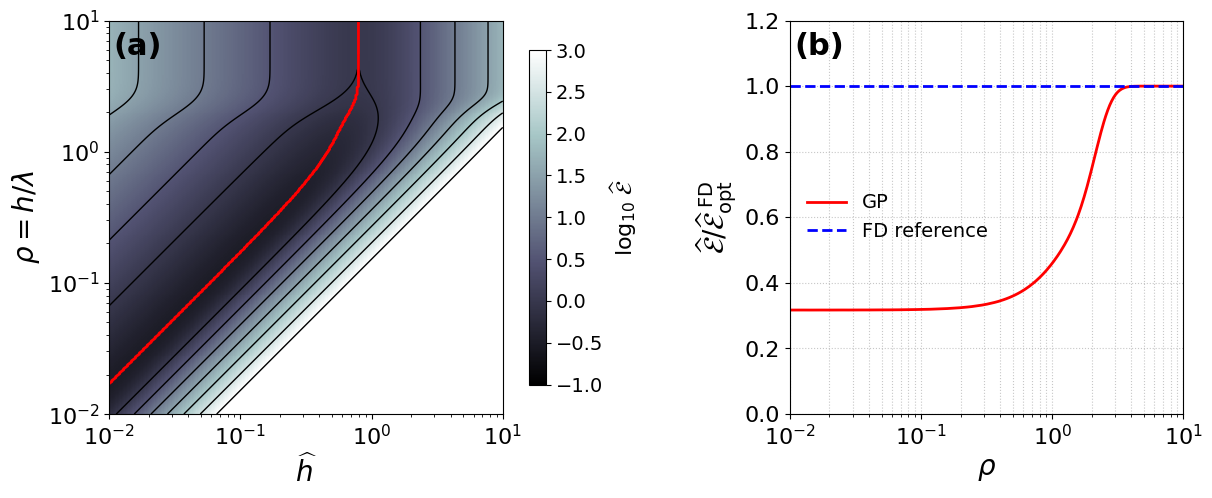

In [13]:
# --- parameter grids (broaden + densify) ---
dQ_vals  = np.logspace(-3, 1, 401)   # \widehat{h}
rho_vals = np.logspace(-2, 1, 401) # \rho

chi = 1.0  # use the correct chi!

# --- compute reduced error surface (NO normalization here) ---
Z = np.empty((rho_vals.size, dQ_vals.size), float)
for i, rho in enumerate(rho_vals):
    G = G_of_rho(rho)
    for j, dQ in enumerate(dQ_vals):
        mu2 = mu2_of_rho(rho, dQ)       # see note at the top
        Z[i, j] = G / dQ + dQ**2 + chi * (mu2**2)

# --- detect interior minima via derivative sign-change w.r.t. dQ ---
dQ_min_list = []
rho_min_list = []
E_min_list = []
for i, rho in enumerate(rho_vals):
    Z_row = Z[i, :]
    dZ_ddQ = np.gradient(Z_row, dQ_vals)
    sign_changes = np.where(np.diff(np.sign(dZ_ddQ)))[0]
    idx_min = np.argmin(Z_row)
    dQ_min_list.append(dQ_vals[idx_min])
    rho_min_list.append(rho)
    E_min_list.append(Z_row[idx_min])
E_min_list = np.array(E_min_list)
dQ_min_list = np.array(dQ_min_list)
rho_min_list = np.array(rho_min_list)

X, Y = np.meshgrid(dQ_vals, rho_vals)

# ----------------------------
# Asymptotic optimal lines \widehat{h}_{opt}(\rho)
# ----------------------------
# Large-ρ (weak/no smoothing): \widehat{h}_{opt} = 2^{-1/3}
dQ_opt_large = 2.0 ** (-1.0/3.0)

# Small-ρ (strong smoothing): \widehat{h}_{opt} ~ ρ * (1/(8 sqrt(pi) χ))^{1/5}
# Eq. (\ref{eq:opt-small-rho})
pref_small = (1.0 / (8.0 * np.sqrt(np.pi) * chi)) ** (1.0/5.0)
dQ_opt_small_curve = rho_vals * pref_small

# ----------------------------
# Plot
# ----------------------------
# fig = plt.figure(figsize=(7, 6))
# gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)
# ax1 = fig.add_subplot(gs[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
CS = ax1.contour(X, Y, np.log10(Z/E_FD_extreme), levels=np.linspace(-1, 3, 9), linewidths=1, colors='k')
CSf = ax1.pcolormesh(X, Y, np.log10(Z/E_FD_extreme), vmax=3, vmin=-1, shading='nearest', cmap='bone')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\widehat{h}$', fontsize=20)
ax1.set_ylabel(r'$\rho=h/\lambda$', fontsize=20)
ax1.set_aspect('equal', adjustable='box')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.text(0.01, 0.97, '(a)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='left', color='k')

ax1.plot(dQ_min_list, rho_min_list, 'r-', lw=2, label=r'$\widehat{h}_\mathrm{opt}(\rho)$ (small $\rho$)')

ax1.set_xlim(1e-2, 1e1)
ax1.set_ylim(1e-2, 1e1)

# Colorbar
# cax = fig.add_subplot(gs[1])
# cbar = plt.colorbar(CSf, cax=cax)
cbar = plt.colorbar(CSf, ax=ax1, shrink=0.85)
cbar.set_label(r'$\log_{10}\,\widehat{\mathcal{E}}\,$', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# ---- OO-style plotting ----
# ax2.plot(rho_red, E_red/E_FD_extreme, '-', linewidth=2.3, color='red', label='GPR')
ax2.plot(rho_min_list, E_min_list/E_FD_extreme, '-', linewidth=2, color='red', label='GP')
# ax.loglog(rho_mag, E_mag/E_FD_extreme, '-', linewidth=2.3, color='magenta', label='F–D (ρ≥1)')
ax2.plot(rho_min_list, np.ones_like(rho_min_list), '--', linewidth=2, color='b', alpha=1, label='FD reference')
ax2.set_xscale('log')

ax2.set_xlabel(r'$\rho$', fontsize=20)
ax2.set_ylabel(r'$\widehat{\mathcal{E}}/\widehat{\mathcal{E}}_\mathrm{opt}^\mathrm{\ FD}$', fontsize=20)
ax2.grid(True, which='both', ls=':', alpha=0.7)
ax2.tick_params(axis='both', labelsize=16)
ax2.legend(frameon=False, fontsize=14, loc='center left')
ax2.set_xlim(1e-2, 1e1)
ax2.set_ylim(0,1.2)
ax2.text(0.01, 0.97, '(b)', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top', ha='left', color='k')
ax2.set_aspect(3/1.2)

plt.tight_layout()
plt.show()
